<a href="https://colab.research.google.com/github/rage-against-the-machine-learning/cs7643-DL-Group-Project/blob/coco-embed-stran/CNN_AE_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://cs7643-raml.s3.us-west-2.amazonaws.com/valid_subset_np_imgs.zip

--2021-08-02 06:00:27--  https://cs7643-raml.s3.us-west-2.amazonaws.com/valid_subset_np_imgs.zip
Resolving cs7643-raml.s3.us-west-2.amazonaws.com (cs7643-raml.s3.us-west-2.amazonaws.com)... 52.218.182.234
Connecting to cs7643-raml.s3.us-west-2.amazonaws.com (cs7643-raml.s3.us-west-2.amazonaws.com)|52.218.182.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2915042448 (2.7G) [application/zip]
Saving to: ‘valid_subset_np_imgs.zip’

valid_subset_np_img  76%[==============>     ]   2.07G  24.7MB/s    eta 28s    

In [ ]:
!unzip valid_subset_np_imgs.zip

In [ ]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from os import listdir
from os.path import isfile, join

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import collections
import pickle

In [ ]:
mypath = '/content/valid_subset/'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]


In [ ]:
!rm valid_subset_np_imgs.zip

In [ ]:
images = []
for f in files:
  images.append(np.load('/content/valid_subset/'+f))
print(len(images))


21002


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

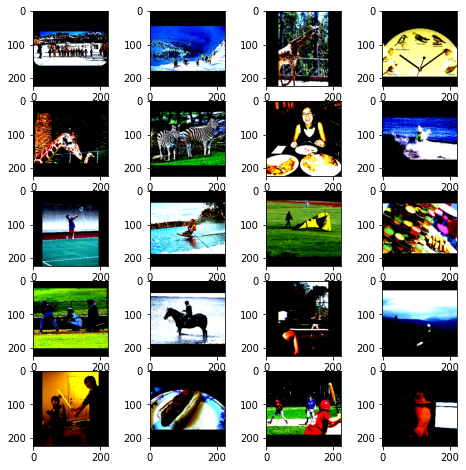

In [ ]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = images[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    
plt.show()

In [ ]:
# images N * 224 * 224 * 3
images = np.transpose(np.array(images),(0,3,1,2))

In [ ]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
  print("GPU!")
else:  
  dev = "cpu"  
device = torch.device(dev) 

GPU!


In [ ]:
import gc
gc.collect()

146

In [ ]:
dev_images = torch.FloatTensor(images).to(device)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=(3,3)),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4),
            #nn.MaxPool2d(kernel_size=(3,3))
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            # nn.ConvTranspose2d(128, 128, 3, stride=2, padding=1, output_padding=1),
            # nn.ReLU(),
            nn.Upsample((112,112)),
            nn.ConvTranspose2d(128, 1, 3, stride=2, padding=1, output_padding=1),
          
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
model = Autoencoder()
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): Upsample(size=(112, 112), mode=nearest)
    (7): ConvTranspose2d(128, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
from torchsummary import summary
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             448
         MaxPool2d-2           [-1, 16, 56, 56]               0
              ReLU-3           [-1, 16, 56, 56]               0
            Conv2d-4           [-1, 32, 28, 28]           4,640
         MaxPool2d-5             [-1, 32, 9, 9]               0
              ReLU-6             [-1, 32, 9, 9]               0
            Conv2d-7             [-1, 64, 6, 6]          32,832
   ConvTranspose2d-8             [-1, 32, 9, 9]          32,800
              ReLU-9             [-1, 32, 9, 9]               0
  ConvTranspose2d-10           [-1, 64, 18, 18]          18,496
             ReLU-11           [-1, 64, 18, 18]               0
  ConvTranspose2d-12          [-1, 128, 36, 36]          73,856
             ReLU-13          [-1, 128, 36, 36]               0
         Upsample-14        [-1, 128, 1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
# specify loss function
criterion = nn.MSELoss().to(device)

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trainloader = DataLoader(
    dev_images, 
    batch_size=64,
    shuffle=True
)

In [ ]:
# number of epochs to train the model
n_epochs = 20
outputs = []
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in trainloader:
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, data)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
    # print avg training statistics 
    train_loss = train_loss/len(trainloader)
    outputs.append((epoch, data, output),)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([64, 3, 224, 224])) that is different to the input size (torch.Size([64, 1, 224, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([10, 3, 224, 224])) that is different to the input size (torch.Size([10, 1, 224, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 	Training Loss: 39.522557
Epoch: 2 	Training Loss: 29.192076
Epoch: 3 	Training Loss: 27.934193
Epoch: 4 	Training Loss: 27.209359
Epoch: 5 	Training Loss: 26.746674
Epoch: 6 	Training Loss: 26.437351
Epoch: 7 	Training Loss: 26.181256
Epoch: 8 	Training Loss: 26.002502
Epoch: 9 	Training Loss: 25.842966
Epoch: 10 	Training Loss: 25.689665
Epoch: 11 	Training Loss: 25.590554
Epoch: 12 	Training Loss: 25.485413
Epoch: 13 	Training Loss: 25.408951
Epoch: 14 	Training Loss: 25.293128
Epoch: 15 	Training Loss: 25.250535
Epoch: 16 	Training Loss: 25.148498
Epoch: 17 	Training Loss: 25.079738
Epoch: 18 	Training Loss: 25.025260
Epoch: 19 	Training Loss: 24.966758
Epoch: 20 	Training Loss: 24.896900


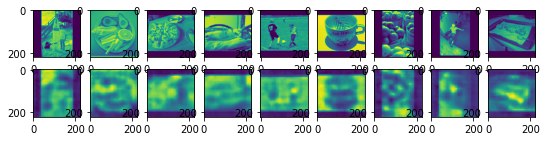

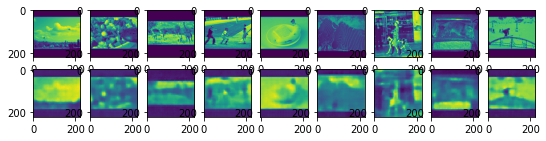

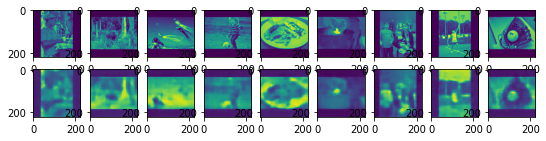

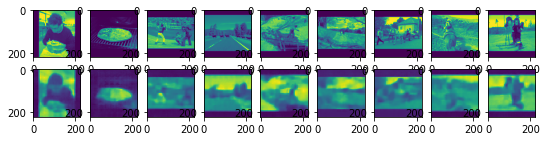

In [ ]:
for k in range(0, 20, 5):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].cpu().detach().numpy()

    recon = outputs[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

In [ ]:
imgs.shape

(10, 3, 224, 224)

In [ ]:
import gc
gc.collect()

125299

In [ ]:
devloader = DataLoader(
    images, 
    batch_size=64,
    shuffle=True
)

In [ ]:
from tqdm import tqdm

In [ ]:
features_lists = []
i = 0
for batch in tqdm(devloader):
  batch = torch.FloatTensor(batch)
  batch = torch.stack([batch])
  with torch.no_grad():
    features_batch = model.cpu().encoder(batch[0]).flatten(start_dim=1)
    features_lists.append(features_batch)
 

100%|██████████| 329/329 [00:53<00:00,  6.16it/s]


In [ ]:
img_emb = collections.defaultdict(list)
img_id = 0
for batch in features_lists:
  for emb in batch:
    img_emb[img_id] = emb.tolist()
    img_id += 1


In [ ]:
# import json
# with open('val_img_emb.json', 'w') as fp:
#     json.dump(img_emb, fp)

In [ ]:
!pip install annoy

     |████████████████████████████████| 646 kB 5.2 MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391656 sha256=d7efc7c0402528c620cbfca3ae029250472550bbed42b180f9b40de19d4526e3
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy


In [ ]:
len(img_emb[0])

2304

In [ ]:
from annoy import AnnoyIndex
import random

f = 2304
t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
for i in range(len(img_emb)):
    t.add_item(i, img_emb[i])

t.build(10) # 10 trees


True

In [ ]:
t.save('test.ann')

# ...

u = AnnoyIndex(f, 'angular')
u.load('test.ann') # super fast, will just mmap the file

True

In [ ]:
u.get_nns_by_item(1, 10) 


[1, 9061, 8942, 16963, 14410, 7349, 17661, 16840, 17275, 19691]

In [ ]:
from annoy import AnnoyIndex
import random

f = 2304
t = AnnoyIndex(f, 'angular') 
for i in range(len(img_emb)):
    t.add_item(i, img_emb[i])
t.build(10) # 10 trees
t.save('test.ann')

u = AnnoyIndex(f, 'angular')
u.load('test.ann') 
def id2img(image_id):
  a = images[image_id]
  imgs = torch.FloatTensor(a).permute(1, 2, 0).numpy()
  print("original image id :", image_id)
  plt.imshow(imgs)
  plt.show()
  sim_imgs = u.get_nns_by_item(image_id, 10)

  print("similar images ids:", sim_imgs)
  for img in sim_imgs:
    if img==img_id:
      continue
    a = images[img]
    imgs = torch.FloatTensor(a).permute(1, 2, 0).numpy()
    plt.imshow(imgs)
    plt.show()

  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.39 µs
original image id : 4857


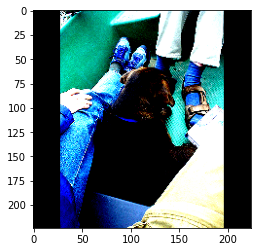

similar images ids: [4857, 7936, 12297, 14601, 19089, 13031, 6819, 2553, 10511, 14015]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


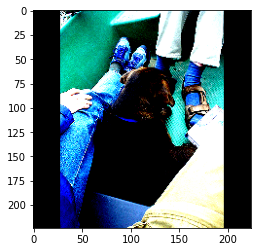

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


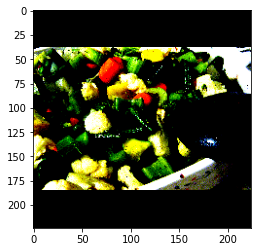

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


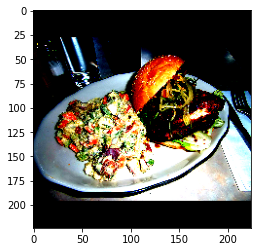

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


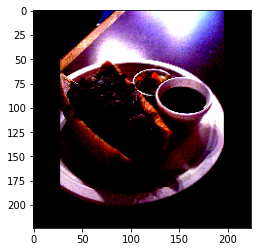

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


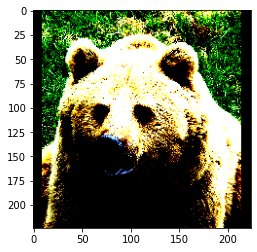

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


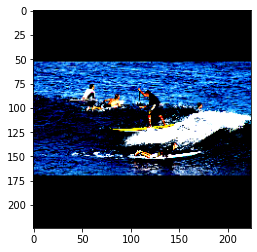

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


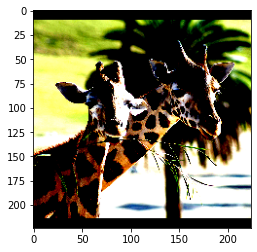

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


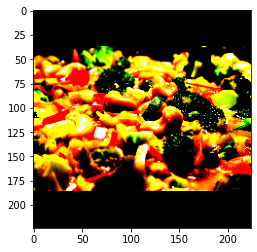

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


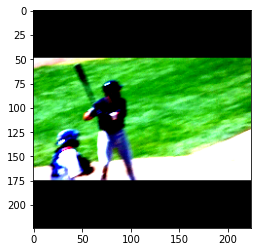

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


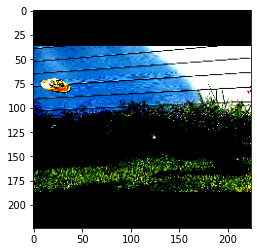

In [ ]:
%time
id2img(4857)